# Model import using the PEtab format

In this notebook, we illustrate how to use [pyPESTO](https://github.com/icb-dcm/pypesto.git) together with [PEtab](https://github.com/petab-dev/petab.git) and [AMICI](https://github.com/icb-dcm/amici.git). The notebook first details the individual steps of the import and the creation of the objective function. Note that those can steps can be summarised, demonstrated at the end of the 'Import' section. After that optimization and visualisation are showcased.
We employ models from the [benchmark collection](https://github.com/benchmarking-initiative/benchmark-models-petab), which we first download:

In [2]:
# install if not done yet
# !apt install libatlas-base-dev swig
!pip install pypesto[amici,petab] --quiet
!pip install git+https://github.com/Benchmarking-Initiative/Benchmark-Models-PEtab.git@master#subdirectory=src/python --quiet


[notice] A new release of pip available: 22.3.1 -> 23.3
[notice] To update, run: pip install --upgrade pip


In [3]:
import os

import amici
import benchmark_models_petab as models
import matplotlib.pyplot as plt
import numpy as np
import petab

import pypesto
import pypesto.optimize as optimize
import pypesto.petab
import pypesto.visualize as visualize

## Import

### Manage PEtab model

A PEtab problem comprises all the information on the model, the data and the parameters to perform parameter estimation. We import a model as a `petab.Problem`.

In [4]:
# a collection of models that can be simulated

# model_name = "Zheng_PNAS2012"
model_name = "Boehm_JProteomeRes2014"
# model_name = "Fujita_SciSignal2010"
# model_name = "Sneyd_PNAS2002"
# model_name = "Borghans_BiophysChem1997"
# model_name = "Elowitz_Nature2000"
# model_name = "Crauste_CellSystems2017"
# model_name = "Lucarelli_CellSystems2018"
# model_name = "Schwen_PONE2014"
# model_name = "Blasi_CellSystems2016"

# the yaml configuration file links to all needed files
yaml_config = os.path.join(models.MODELS_DIR, model_name, model_name + ".yaml")

# create a petab problem
petab_problem = petab.Problem.from_yaml(yaml_config)

### Import model to AMICI

The model must be imported to pyPESTO and AMICI. Therefore, we create a `pypesto.PetabImporter` from the problem, and create an AMICI model.

In [5]:
importer = pypesto.petab.PetabImporter(petab_problem)

model = importer.create_model()

# some model properties
print("Model parameters:", list(model.getParameterIds()), "\n")
print("Model const parameters:", list(model.getFixedParameterIds()), "\n")
print("Model outputs:   ", list(model.getObservableIds()), "\n")
print("Model states:    ", list(model.getStateIds()), "\n")

Model parameters: ['Epo_degradation_BaF3', 'k_exp_hetero', 'k_exp_homo', 'k_imp_hetero', 'k_imp_homo', 'k_phos', 'noiseParameter1_pSTAT5A_rel', 'noiseParameter1_pSTAT5B_rel', 'noiseParameter1_rSTAT5A_rel'] 

Model const parameters: ['ratio', 'specC17'] 

Model outputs:    ['pSTAT5A_rel', 'pSTAT5B_rel', 'rSTAT5A_rel'] 

Model states:     ['STAT5A', 'STAT5B', 'pApB', 'pApA', 'pBpB', 'nucpApA', 'nucpApB', 'nucpBpB'] 



### Create objective function

To perform parameter estimation, we need to define an objective function, which integrates the model, data, and noise model defined in the PEtab problem.

Creating the objective from PEtab with default settings can be done in as many as two lines.

In [6]:
importer = pypesto.petab.PetabImporter.from_yaml(
    yaml_config
)  # creating an importer
problem = (
    importer.create_problem()
)  # creating the problem from the importer. The objective can be found at problem.objective

If we need more flexibility, by defining whether you need residuals of the objective function, what sensitivities you want to use or fix certain parameters, you can also create the problem from a customized objective:

In [7]:
import libsbml

converter_config = libsbml.SBMLLocalParameterConverter().getDefaultProperties()
petab_problem.sbml_document.convert(converter_config)

obj = importer.create_objective()

# for some models, hyperparamters need to be adjusted
# obj.amici_solver.setMaxSteps(10000)
# obj.amici_solver.setRelativeTolerance(1e-7)
# obj.amici_solver.setAbsoluteTolerance(1e-7)

We can request variable derivatives via `sensi_orders`, function values or residuals as specified via `mode`. Passing `return_dict`, we obtain the direct result of the AMICI simulation.

In [8]:
ret = obj(
    petab_problem.x_nominal_scaled,
    mode="mode_fun",
    sensi_orders=(0, 1),
    return_dict=True,
)
print(ret)

{'fval': 138.22199566457704, 'grad': array([ 2.20546436e-02,  5.53227499e-02,  5.78876640e-03,  5.42272184e-03,
       -4.51595808e-05,  7.91009669e-03,  0.00000000e+00,  1.07876837e-02,
        2.40388572e-02,  1.91925085e-02,  0.00000000e+00]), 'rdatas': [<ReturnDataView(<amici.amici.ReturnData; proxy of <Swig Object of type 'amici::ReturnData *' at 0x136c75860> >)>]}


The problem defined in PEtab also defines the fixed parameters and parameter bounds. This information is contained in a `pypesto.Problem`.

In [9]:
problem = importer.create_problem(obj)

In particular, the problem accounts for the fixation of parameters.

In [10]:
print(problem.x_fixed_indices, problem.x_free_indices)

[6, 10] [0, 1, 2, 3, 4, 5, 7, 8, 9]


The problem creates a copy of the objective function that takes into account the fixed parameters. The objective function is able to calculate function values and derivatives. A finite difference checks whether the computed gradient is accurate:

In [11]:
objective = problem.objective
ret = objective(petab_problem.x_nominal_free_scaled, sensi_orders=(0, 1))
print(ret)

(138.22199566457704, array([ 2.20546436e-02,  5.53227499e-02,  5.78876640e-03,  5.42272184e-03,
       -4.51595808e-05,  7.91009669e-03,  1.07876837e-02,  2.40388572e-02,
        1.91925085e-02]))


In [12]:
eps = 1e-4


def fd(x):
    grad = np.zeros_like(x)
    j = 0
    for i, xi in enumerate(x):
        mask = np.zeros_like(x)
        mask[i] += eps
        valinc, _ = objective(x + mask, sensi_orders=(0, 1))
        valdec, _ = objective(x - mask, sensi_orders=(0, 1))
        grad[j] = (valinc - valdec) / (2 * eps)
        j += 1
    return grad


fdval = fd(petab_problem.x_nominal_free_scaled)
print("fd: ", fdval)
print("l2 difference: ", np.linalg.norm(ret[1] - fdval))

fd:  [ 0.02993985  0.05897443 -0.00149735 -0.00281785 -0.00925273  0.01197046
  0.01078638  0.02403756  0.01919121]
l2 difference:  0.017256061672716528


## Run optimization

Given the problem, we can perform optimization. We can specify an optimizer to use, and a parallelization engine to speed things up.

In [13]:
optimizer = optimize.ScipyOptimizer()

# engine = pypesto.engine.SingleCoreEngine()
engine = pypesto.engine.MultiProcessEngine()

# do the optimization
result = optimize.minimize(
    problem=problem, optimizer=optimizer, n_starts=10, engine=engine
)

Engine will use up to 8 processes (= CPU count).
  0%|                                                                                                                                                                                                                                                                                                                                                                                                     | 0/10 [00:00<?, ?it/s]2023-10-19 06:45:13.773 - amici.swig_wrappers - DEBUG - [model1_data1][CVODES:CVode:TOO_MUCH_WORK] AMICI ERROR: in module CVODES in function CVode : At t = 76.964, mxstep steps taken before reaching tout. 
2023-10-19 06:45:13.773 - amici.swig_wrappers - ERROR - [model1_data1][FORWARD_FAILURE] AMICI forward simulation failed at t = 76.964: AMICI failed to integrate the forward problem
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

## Visualize

The results are contained in a `pypesto.Result` object. It contains e.g. the optimal function values.

In [14]:
result.optimize_result.fval

[149.58803749424618,
 149.58814563446273,
 164.42567030939725,
 164.425688940287,
 171.13407625282218,
 195.29062702870243,
 249.74566835638407,
 249.74599744206262,
 468.016639842034,
 34832329986.32791]

We can use the standard pyPESTO plotting routines to visualize and analyze the results.

<Axes: title={'center': 'Estimated parameters'}, xlabel='Parameter value', ylabel='Parameter'>

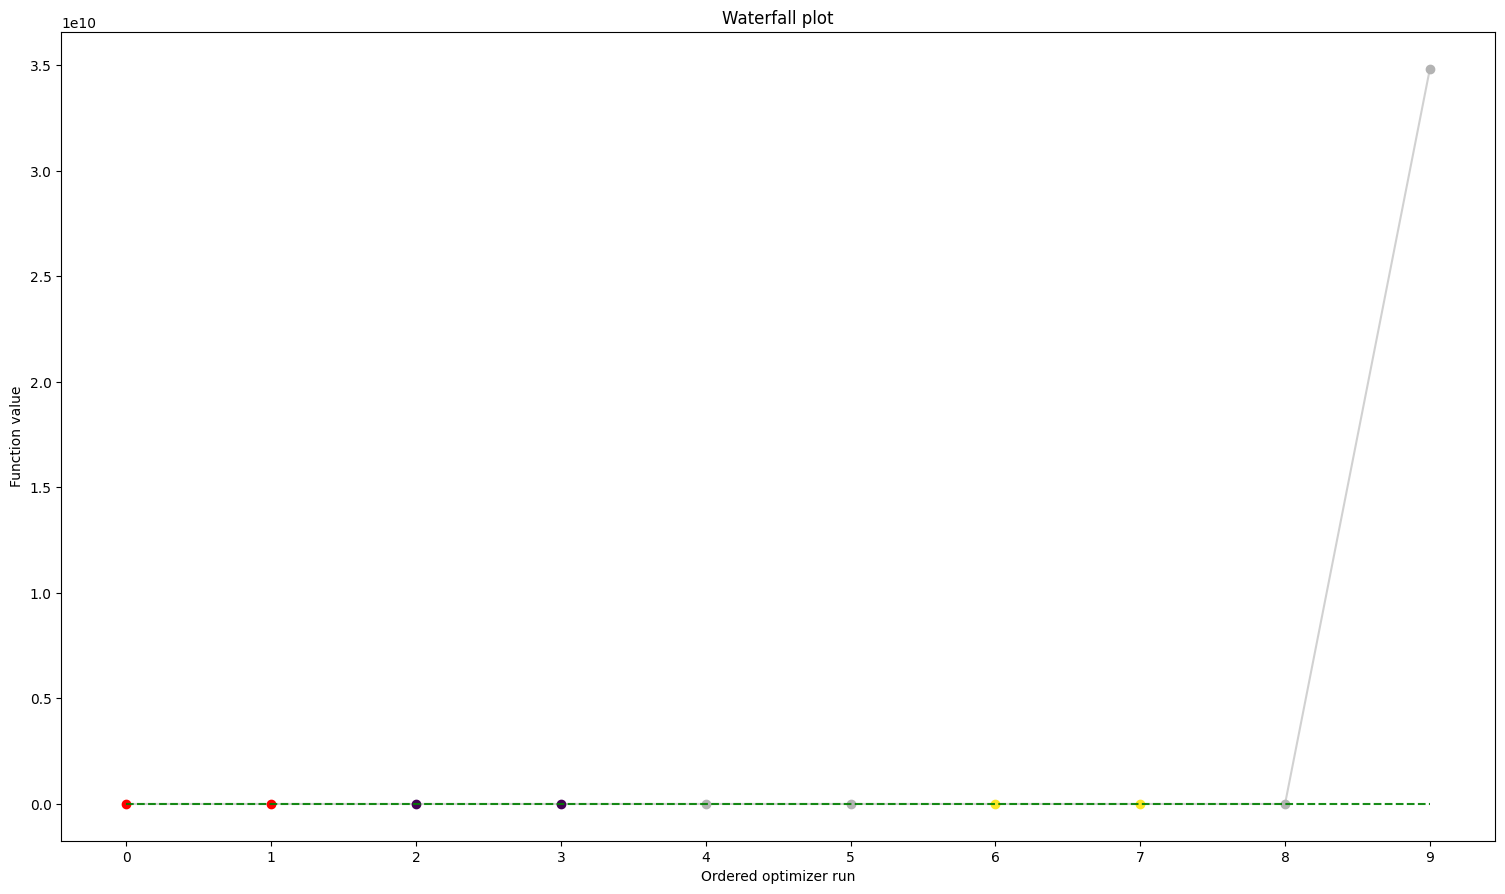

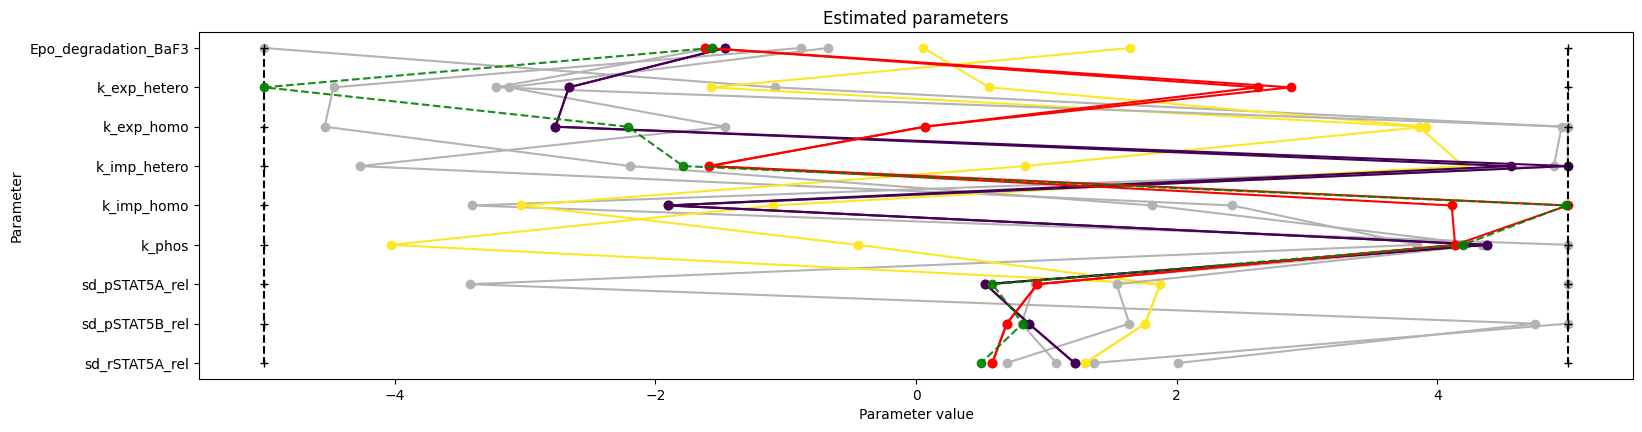

In [15]:
ref = visualize.create_references(
    x=petab_problem.x_nominal_scaled, fval=obj(petab_problem.x_nominal_scaled)
)

visualize.waterfall(result, reference=ref, scale_y="lin")
visualize.parameters(result, reference=ref)

We can also conveniently visualize the model fit. This plots the petab visualization using optimized parameters.

{'plot1': <Axes: title={'center': 'pSTAT5A_rel'}, xlabel='Time [min]', ylabel='frac. [%]'>,
 'plot2': <Axes: title={'center': 'pSTAT5B_rel'}, xlabel='Time [min]', ylabel='frac. [%]'>,
 'plot3': <Axes: title={'center': 'rSTAT5A_rel'}, xlabel='Time [min]', ylabel='relative STAT5A abundance [%]'>}

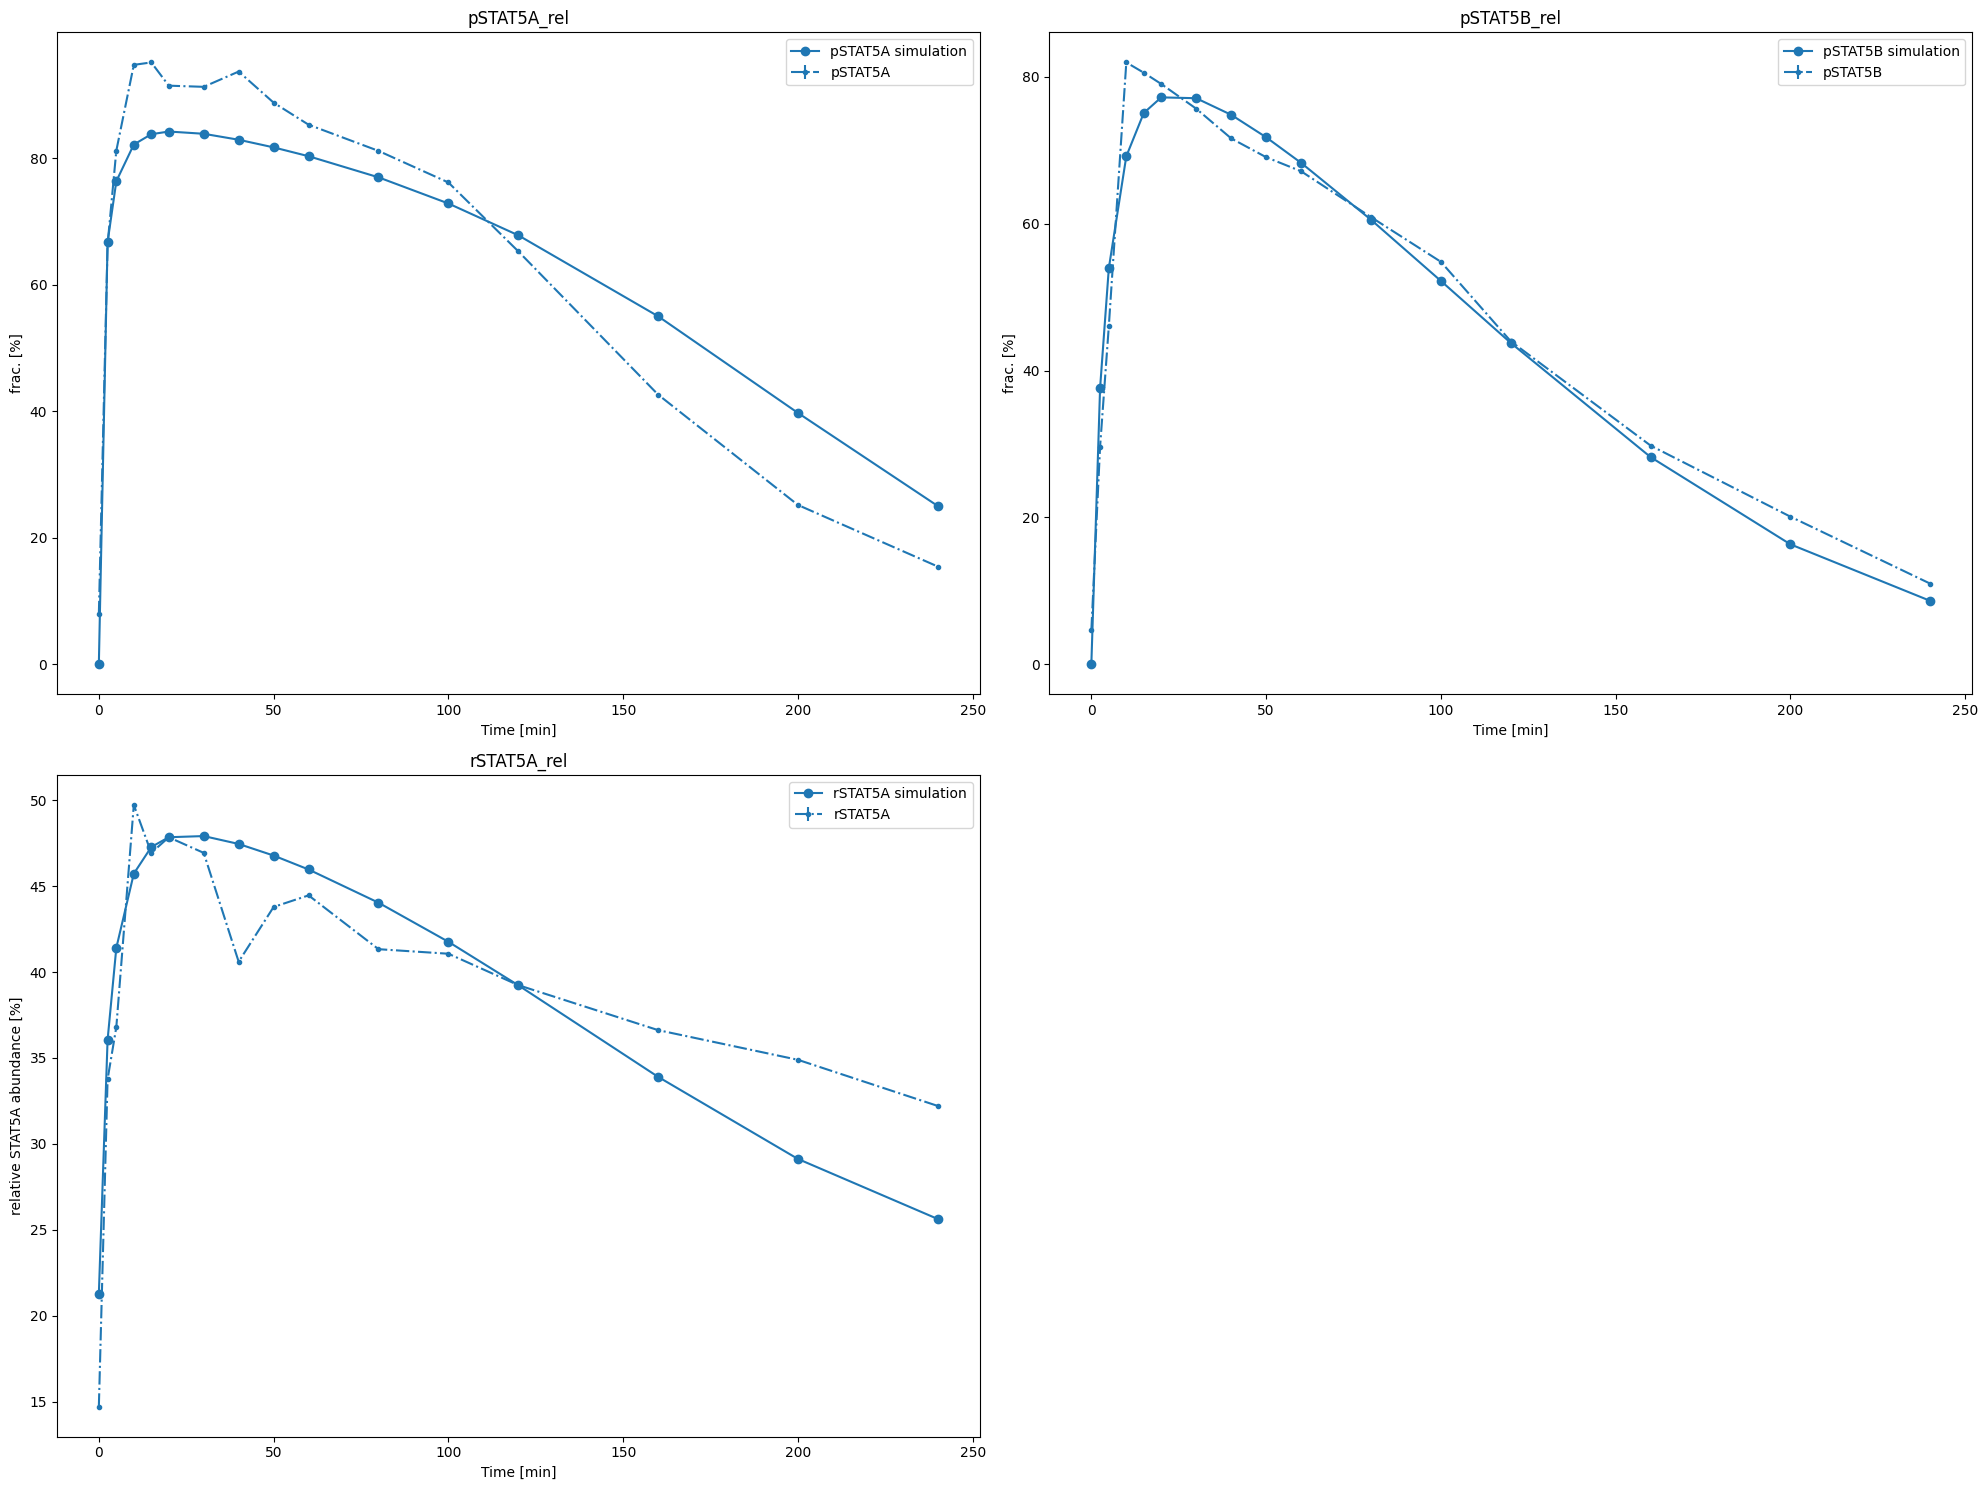

In [16]:
# we need to explicitely import the method
from pypesto.visualize.model_fit import visualize_optimized_model_fit

visualize_optimized_model_fit(
    petab_problem=petab_problem, result=result, pypesto_problem=problem
)